# Financial Markets Project
Deep Learning and Applied AI at Sapienza Univerisity 2021 

Author: Klaudia Palak and Hossein

In [1]:
# Installation 
!pip install pandas-ta
!pip install yfinance
# Import
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
# Clear
from IPython.display import clear_output 
clear_output()

## Dataset preparation

### Load data

In [2]:
dataset = yf.download('AAPL','2012-01-01','2021-06-01')
print (dataset.head())
print (dataset.count())

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2012-01-03  14.621429  14.732143  14.607143  14.686786  12.629209  302220800
2012-01-04  14.642857  14.810000  14.617143  14.765714  12.697079  260022000
2012-01-05  14.819643  14.948214  14.738214  14.929643  12.838044  271269600
2012-01-06  14.991786  15.098214  14.972143  15.085714  12.972249  318292800
2012-01-09  15.196429  15.276786  15.048214  15.061786  12.951672  394024400
Open         2367
High         2367
Low          2367
Close        2367
Adj Close    2367
Volume       2367
dtype: int64


In [3]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    # number of GPUs from cuda
    GPU_numbers = torch.cuda.device_count()
    print("Available GPUs:", GPU_numbers)
    print("GPU {}: {}".format(1, torch.cuda.get_device_name(0)))
else:
    device = torch.device("cpu")
print(device)

cpu


In [4]:
class Timedata(Dataset):
    def __init__(self, data_frame, length_seq=2):
        self.data = torch.tensor(data_frame.values)
        self.length_seq = length_seq

    def __len__(self):
        return self.data.shape[0] - self.length_seq + 1

    def __getitem__(self, index):
        return self.data[index: index + self.length_seq].float()

## Hyperparameters

In [5]:
num_epochs = 50 #@param {type:"slider", min:1, max:2000, step:1}
batch_size = 64 #@param {type:"slider", min:1, max:100, step:1}
learning_rate = 5e-4 #@param {type:"number"}
optimizer_betas = (0.9, 0.999)

device = torch.device("cuda:0" if (torch.cuda.is_available() and GPU_numbers > 1) else "cpu")

### Create dataset and dataloader

In [6]:
#@title Timesteps for creating dataset
length_seq = 5 #@param {type:"slider", min:1, max:50, step:1}

# create pytorch dataset 
training_columns = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
data_dimension = len(training_columns)


train_data, rest_data = train_test_split(dataset[training_columns], test_size=0.2, shuffle=False)
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data[train_data.columns] = scaler.transform(train_data)
rest_data[rest_data.columns] = scaler.transform(rest_data)

validation_data, test_data = train_test_split(rest_data, test_size=0.5, shuffle=False)

train_dataset = Timedata(train_data, length_seq)
test_dataset = Timedata(test_data, length_seq)
validation_dataset = Timedata(validation_data, length_seq)

# create the dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_data))
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)
real_data_sample = next(iter(train_dataloader))
print("Real data sample shape:", real_data_sample.shape)

Real data sample shape: torch.Size([64, 5, 6])


## Model

Constructor of the class accepts:

*   input_size: Corresponds to the number of features in the input. 
*   hidden_layer_size: Specifies the number of hidden layers along with the number of neurons in each layer.
*   output_size: The number of items in the output, since we want to predict the close price for the end of the day, the output size will be 1.






In [7]:
# Be careful! In our case we want to use 6 training_columns, so input_dim
# and output_dim are 6! 
#@title Parameters of the Model
input_dim =  6#@param {type:"integer"}
hidden_dim = 40 #@param {type:"integer"}
num_layers = 1 #@param {type:"integer"}
output_dim =  6#@param {type:"integer"}

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # I just want last time step hidden states!!!!
        out = self.fc(out[:, -1, :])
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(reduction='sum')

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=optimizer_betas)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(6, 40, batch_first=True)
  (fc): Linear(in_features=40, out_features=6, bias=True)
)
6
torch.Size([160, 6])
torch.Size([160, 40])
torch.Size([160])
torch.Size([160])
torch.Size([6, 40])
torch.Size([6])


In [8]:
def model_RMSE(model, dataloader, plot_graph=False, plot_title="Validation Predictions"):
    RMSE = 0
    squared_error_list = []
    real_data_list = []
    predicted_data_list = []
    for i, sequence_batch in enumerate(dataloader):
        with torch.no_grad():
            seq_real = sequence_batch
            seq_input_gen = sequence_batch[:,:-1].to(device)
            real_values = sequence_batch[:,-1,:]
            predicted_values = model(seq_input_gen).cpu()

            squared_error_list.append((predicted_values - real_values) ** 2)
            real_data_list.append(real_values)
            predicted_data_list.append(predicted_values)
    squared_errors = torch.cat(squared_error_list, 0)
    real_data = torch.cat(real_data_list, 0)
    predicted_data = torch.cat(predicted_data_list, 0)
    if plot_graph:
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title(plot_title)
        plt.plot(real_data[:,0].view(-1),label="Real")
        plt.plot(predicted_data[:,0].view(-1),label="Predicted")
        plt.ylim(bottom=0)
        plt.legend()
        plt.show()
    RMSE = np.sqrt(squared_errors.mean())
    return RMSE

## Train Model

In [9]:
if not os.path.exists('./models/'):
    os.makedirs('./models/')

Training is started


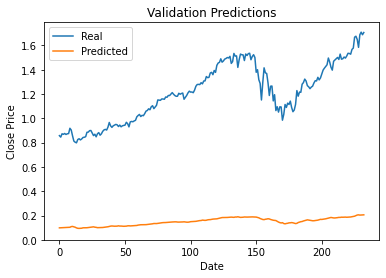


[1/50]	RMSE:0.9067
Open | Real:0.5598 / Generated:0.0701
High | Real:0.5577 / Generated:0.1513
Low | Real:0.5600 / Generated:0.2360
Close | Real:0.5654 / Generated:0.2875
Adj Close | Real:0.5627 / Generated:0.0248
Volume | Real:0.0449 / Generated:0.0603


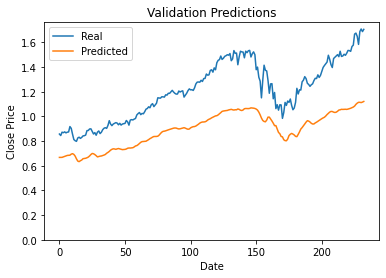


[5/50]	RMSE:0.2956
Open | Real:0.2957 / Generated:0.2903
High | Real:0.2851 / Generated:0.2925
Low | Real:0.2893 / Generated:0.2850
Close | Real:0.2924 / Generated:0.2836
Adj Close | Real:0.2858 / Generated:0.3040
Volume | Real:0.0992 / Generated:0.1419


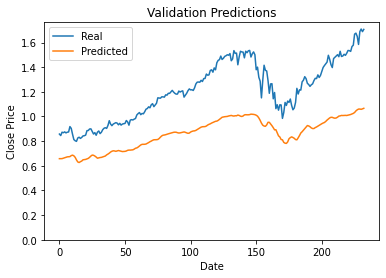


[10/50]	RMSE:0.3066
Open | Real:0.3031 / Generated:0.2966
High | Real:0.2926 / Generated:0.2870
Low | Real:0.2985 / Generated:0.3030
Close | Real:0.2923 / Generated:0.3021
Adj Close | Real:0.2857 / Generated:0.2754
Volume | Real:0.0379 / Generated:0.1250


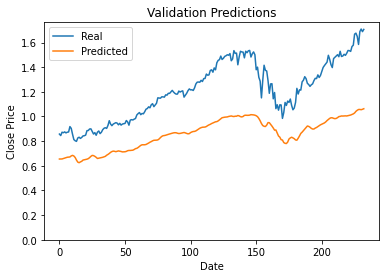


[15/50]	RMSE:0.3092
Open | Real:0.3485 / Generated:0.3314
High | Real:0.3566 / Generated:0.3191
Low | Real:0.3520 / Generated:0.3309
Close | Real:0.3627 / Generated:0.3282
Adj Close | Real:0.3480 / Generated:0.3199
Volume | Real:0.1194 / Generated:0.1310


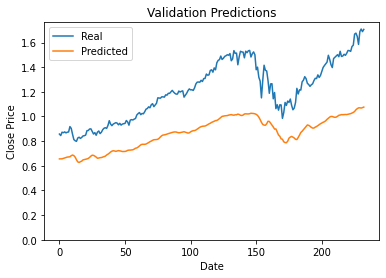


[20/50]	RMSE:0.3023
Open | Real:0.0895 / Generated:0.0870
High | Real:0.0848 / Generated:0.0867
Low | Real:0.0885 / Generated:0.0731
Close | Real:0.0875 / Generated:0.0640
Adj Close | Real:0.0809 / Generated:0.0835
Volume | Real:0.4867 / Generated:0.3370


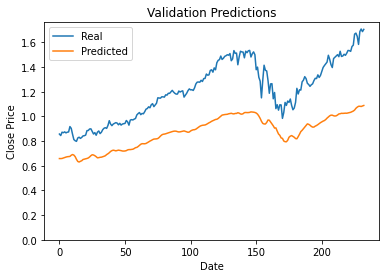


[25/50]	RMSE:0.2949
Open | Real:0.0302 / Generated:0.0550
High | Real:0.0258 / Generated:0.0568
Low | Real:0.0325 / Generated:0.0623
Close | Real:0.0299 / Generated:0.0769
Adj Close | Real:0.0281 / Generated:0.0268
Volume | Real:0.1345 / Generated:0.2186


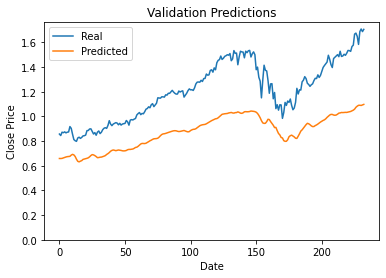


[30/50]	RMSE:0.2937
Open | Real:0.7692 / Generated:0.7808
High | Real:0.7657 / Generated:0.7788
Low | Real:0.7686 / Generated:0.7750
Close | Real:0.7630 / Generated:0.7721
Adj Close | Real:0.7667 / Generated:0.7822
Volume | Real:0.0767 / Generated:0.0583


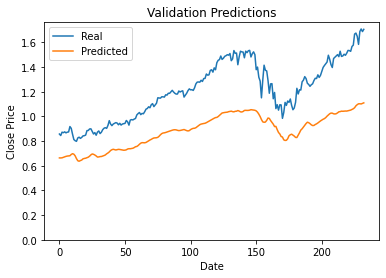


[35/50]	RMSE:0.2855
Open | Real:0.0265 / Generated:0.0341
High | Real:0.0276 / Generated:0.0247
Low | Real:0.0285 / Generated:0.0270
Close | Real:0.0321 / Generated:0.0243
Adj Close | Real:0.0280 / Generated:0.0167
Volume | Real:0.4073 / Generated:0.4079


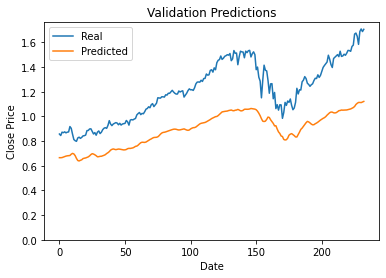


[40/50]	RMSE:0.2818
Open | Real:0.6075 / Generated:0.6043
High | Real:0.6104 / Generated:0.6044
Low | Real:0.6102 / Generated:0.6037
Close | Real:0.6158 / Generated:0.6016
Adj Close | Real:0.6210 / Generated:0.5995
Volume | Real:0.0580 / Generated:0.0938


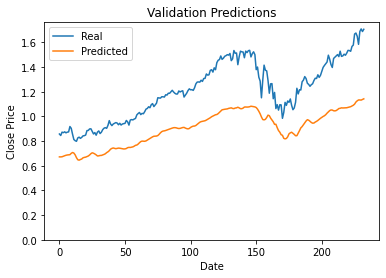


[45/50]	RMSE:0.2713
Open | Real:0.0309 / Generated:0.0436
High | Real:0.0214 / Generated:0.0327
Low | Real:0.0298 / Generated:0.0442
Close | Real:0.0265 / Generated:0.0463
Adj Close | Real:0.0188 / Generated:0.0269
Volume | Real:0.1457 / Generated:0.1868


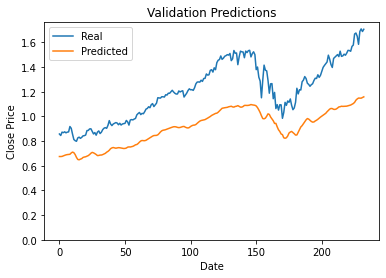


[50/50]	RMSE:0.2618
Open | Real:0.1480 / Generated:0.1489
High | Real:0.1392 / Generated:0.1460
Low | Real:0.1419 / Generated:0.1441
Close | Real:0.1440 / Generated:0.1452
Adj Close | Real:0.1196 / Generated:0.1309
Volume | Real:0.3093 / Generated:0.2990


In [10]:
training_metrics = {"RMSE": []}
evaluation_metrics = {"RMSE":[]}
hist = np.zeros(num_epochs)
                      
print("Training is started")
for epoch in range(num_epochs):
    losses = []
    for i, sequence_batch in enumerate(train_dataloader):
            seq_real = sequence_batch.to(device)
            y_train_pred = model(seq_real)
            y_train = sequence_batch[:,-1,:]
            loss = loss_fn(y_train_pred, y_train)
            if (epoch+1) % 5 == 0 or epoch+1 == 1:
              losses.append(loss.item())
                
            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()

            # Backward pass
            loss.backward()

            # Update parameters
            optimiser.step()
            
    if (epoch+1) % 5 == 0 or epoch+1 == 1:
        training_RMSE = sum(losses) / len(losses)
        training_metrics["RMSE"].append(training_RMSE) 

        RMSE = model_RMSE(model, validation_dataloader, plot_graph=True)
        evaluation_metrics["RMSE"].append(RMSE)
        print('\n[{}/{}]\tRMSE:{:.4f}'.format(epoch+1, num_epochs, RMSE))
        for col_name, real, generated in zip(training_columns, sequence_batch[0][-1], y_train_pred[0]):
            print(f"{col_name} | Real:{real:.4f} / Generated:{generated:.4f}")
        save_path = os.path.join("./models/","model_epoch_{}.pt".format(epoch+1))
        torch.save({
            'epoch': epoch+1,
            'optimizer_lstm_state_dict': optimiser.state_dict(),
            }, save_path)

### Train and validation loss

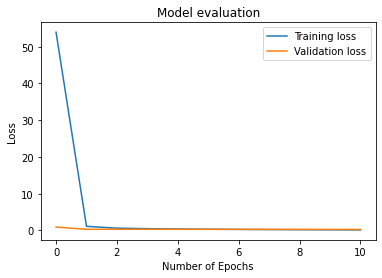

In [11]:
plt.title('Model evaluation')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.plot(training_metrics["RMSE"], label="Training loss")
plt.plot(evaluation_metrics["RMSE"], label="Validation loss")
plt.legend()
plt.show()

## Prediction on test dataset

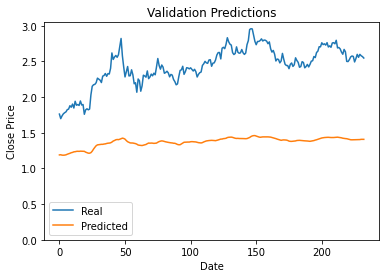


 Test dataset RMSE loss 0.9619


In [12]:
# make predictions on train dataset
for sequence_batch in test_dataloader:
    seq_real = sequence_batch.to(device)
    y_test_pred = model(seq_real)
    y_test = sequence_batch[:,-1,:]
    RMSE = model_RMSE(model, test_dataloader, plot_graph=True)
    print('\n Test dataset RMSE loss {:.4f}'.format(RMSE))